In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

In [2]:
df_feat_sel = pd.read_csv(params.feat_sel_csv, index_col=0, parse_dates=True)

df_feat_sel

r_5      r_15    vol_15  bb_width_20    rsi_14  \
2004-01-02 13:09:00 -0.040971 -0.025534 -0.966783    -0.929333 -1.995735   
2004-01-02 13:10:00 -0.054390 -0.033477 -0.965007    -0.921566 -1.995735   
2004-01-02 13:11:00 -0.067809 -0.041420 -0.963779    -0.913246 -1.995735   
2004-01-02 13:12:00 -0.067810 -0.049363 -0.963001    -0.904541 -1.995735   
2004-01-02 13:13:00 -0.067812 -0.057307 -0.962622    -0.895592 -1.995735   
...                       ...       ...       ...          ...       ...   
2025-06-18 20:56:00  1.742521  1.317936  0.507307     0.122381  0.750521   
2025-06-18 20:57:00  0.887590  1.115397  0.566581     0.187641  0.451158   
2025-06-18 20:58:00  0.341995  0.828890  0.542508     0.241322  0.386888   
2025-06-18 20:59:00 -0.842944 -0.094079  0.903328     0.245429  0.030308   
2025-06-18 21:00:00 -0.468049  0.663058  1.017126     0.236868  0.308515   

                     stoch_k_14  stoch_d_3   hour  macd_12_26  vwap_dev  \
2004-01-02 13:09:00   -1.481580  -1.561625  0.493    0.000000 -0.032030   
2004-01-02 13:10:00   -1.481580  -1.561625  0.493   -1.000000 -0.036171   
2004-01-02 13:11:00   -1.481580  -1.561625  0.493   -1.052039 -0.040262   
2004-01-02 13:12:00   -1.481580  -1.561625  0.493   -1.049817 -0.044296   
2004-01-02 13:13:00   -1.481580  -1.561625  0.493   -1.051188 -0.048268   
...                         ...        ...    ...         ...       ...   
2025-06-18 20:56:00    0.619888   0.342752 -0.939    1.966827  0.407906   
2025-06-18 20:57:00    0.223810   0.415204 -0.939    2.007157  0.263954   
2025-06-18 20:58:00    0.209943   0.370103 -0.939    2.010664  0.254269   
2025-06-18 20:59:00   -0.982637  -0.192907 -0.939    1.616873 -0.173638   
2025-06-18 21:00:00   -0.173363  -0.332445 -0.960    1.550358  0.115538   

                       atr_14     ma_20         bid         ask    signal  
2004-01-02 13:09:00  0.000000  0.000000    0.763664    0.764807  0.077619  
2004-01-02 13:10:00  1.000000 -1.000000    0.763647    0.764790  0.082208  
2004-01-02 13:11:00  1.000000 -1.111111    0.763631    0.764773  0.087074  
2004-01-02 13:12:00  1.000000 -1.133333    0.763614    0.764757  0.092235  
2004-01-02 13:13:00  1.000000 -1.181818    0.763597    0.764740  0.097706  
...                       ...       ...         ...         ...       ...  
2025-06-18 20:56:00  2.101234 -0.132433  196.667400  196.962600  0.417935  
2025-06-18 20:57:00  2.263666 -0.095682  196.527500  196.822500  0.368513  
2025-06-18 20:58:00  2.242849 -0.061664  196.522500  196.817500  0.365417  
2025-06-18 20:59:00  2.504253 -0.063324  196.092800  196.387200  0.280949  
2025-06-18 21:00:00  2.861997 -0.032866  196.392600  196.687400  0.202951  

[3601230 rows x 15 columns]

In [3]:
print('executing <build_lstm_tensors>...')
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

print('executing <chronological_split>...')
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

# how many calendar-days in each split?
print("Days →",
      f"train={len(train_loader.dataset)},",
      f"val={len(val_loader.dataset)},",
      f"test={len(test_loader.dataset)}")

# how many sliding-windows in each split?
print("Windows →",
      f"train={train_loader.dataset.X.shape[0]},",
      f"val={val_loader.dataset.X.shape[0]},",
      f"test={test_loader.dataset.X.shape[0]}")

# how many batches per loader?
print("Batches →",
      f"train={len(train_loader)},",
      f"val={len(val_loader)},",
      f"test={len(test_loader)}")

executing <build_lstm_tensors>...


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

executing <chronological_split>...
executing <split_to_day_datasets>...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days → train=3808, val=783, test=809
Windows → train=1694522, val=353129, test=364691
Batches → train=119, val=783, test=809


Loading checkpoint: dfs_training/AAPL_0.2522.pth

Hyperparameters:
{'ATT_DROPOUT': 0.2,
 'ATT_HEADS': 4,
 'CLIPNORM': 0.5,
 'CLS_LOSS_WEIGHT': 0.05,
 'DROPOUT_LONG': 0.3,
 'DROPOUT_SHORT': 0.25,
 'EARLY_STOP_PATIENCE': 3,
 'ETA_MIN': 1e-06,
 'HUBER_BETA': 0.1,
 'INITIAL_LR': 5e-05,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 3,
 'MAX_EPOCHS': 90,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 96,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 90,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.001}


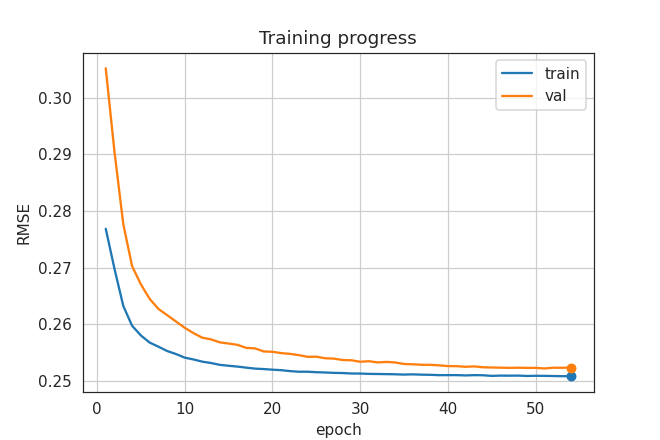


Train metrics: {'rmse': 0.25085514783859253, 'mae': 0.180338054895401, 'r2': 0.23233634233474731, 'acc': 0.751318097114563, 'prec': 0.6595542430877686, 'rec': 0.3499426245689392, 'f1': 0.45726966857910156, 'auroc': 0.7654563188552856}
 Val metrics: {'rmse': 0.2523666024208069, 'mae': 0.17489615082740784, 'r2': 0.1609629988670349, 'acc': 0.7590031027793884, 'prec': 0.688408613204956, 'rec': 0.3251941502094269, 'f1': 0.4417242407798767, 'auroc': 0.7725598812103271}


DualMemoryLSTM(
  (conv): Conv1d(12, 12, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(12, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [4]:
device = params.device

# 1) Pick the best checkpoint file
model_path = min(
    params.save_path.glob(f"{params.ticker}_*.pth"),
    key=lambda p: float(p.stem.split("_")[-1])
)
print("Loading checkpoint:", model_path)

# 2) Load the on-disk dict (all tensors on CPU, no code executed)
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

# 3) Inspect metadata, plots, metrics
print("\nHyperparameters:")
pprint(ckpt["hparams"])

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# 4) Reinstantiate a *clean* model in CPU memory
model_best = models.DualMemoryLSTM(
    n_feats       = X.shape[-1],    
    short_units   = ckpt["hparams"]["SHORT_UNITS"],
    long_units    = ckpt["hparams"]["LONG_UNITS"],
    dropout_short = ckpt["hparams"]["DROPOUT_SHORT"],
    dropout_long  = ckpt["hparams"]["DROPOUT_LONG"],
    att_heads     = ckpt["hparams"]["ATT_HEADS"],
    att_drop      = ckpt["hparams"]["ATT_DROPOUT"]
)

# 5) Load *only* the weight tensors into that fresh model
model_best.load_state_dict(ckpt["model_state_dict"])

# 6) Finally—and only now—move to GPU (or keep on CPU)
model_best.to(device)
model_best.eval()

# 7) Ready for inference!
model_best


In [5]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.41489
Test zero‐forecast baseline RMSE = 0.39967


std val: 0.2755126
std test: 0.2639429


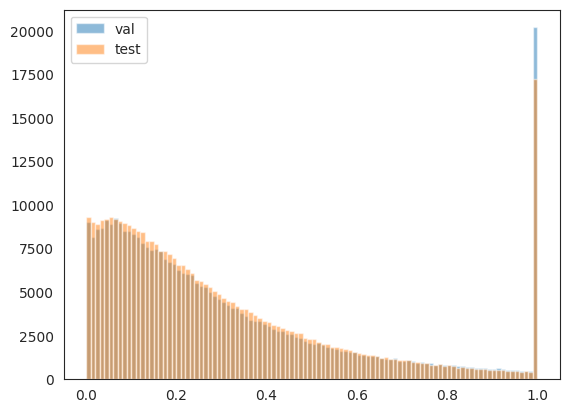

In [6]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [7]:
def make_preds_and_eval(model, loader, device, split_name: str):
    """
    Run inference over a DataLoader for a stateful CNN→BiLSTM→Attention→BiLSTM model 
    with three heads (regression, binary, ternary), compute metrics, and collect predictions.

    Functionality:
      1) Put model in eval mode and reset LSTM hidden states.
      2) Create torchmetrics objects for:
         - regression: RMSE, MAE, R2
         - binary (sig > threshold): accuracy, precision, recall, F1, AUROC
         - ternary (down/flat/up): multiclass accuracy, precision, recall, F1, AUROC
      3) For each batch in loader (no grad):
         a) Unpack padded sequences, move to device.
         b) For each sequence in the batch:
            • Slice to its true length.
            • Reset or carry LSTM states on day rollover.
            • Forward pass → raw_reg, raw_bin, raw_ter logits.
            • Sigmoid‐activate the regression head so pr ∈ [0,1].
            • Sigmoid/softmax the other heads for probabilities.
            • Update all metrics on the unpadded windows.
            • Append pr to the predictions list.
      4) After looping, compute final metric values.
      5) Print metrics in the format:
         R: … | B: … | T: …
      6) Return (metrics_dict, concatenated_predictions).

    Returns:
      metrics_dict: Dict[str, float] of computed metrics.
      all_preds:    numpy array of all sigmoid’d regression outputs.
    """
    # 1) Prepare model
    model.to(device).eval()
    model.h_short = model.h_long = None

    # 2) Instantiate metrics on target device
    thr        = 0.5
    rmse_m     = torchmetrics.MeanSquaredError(squared=False).to(device)
    mae_m      = torchmetrics.MeanAbsoluteError().to(device)
    r2_m       = torchmetrics.R2Score().to(device)

    acc_m      = torchmetrics.classification.BinaryAccuracy(threshold=thr).to(device)
    prec_m     = torchmetrics.classification.BinaryPrecision(threshold=thr).to(device)
    rec_m      = torchmetrics.classification.BinaryRecall(threshold=thr).to(device)
    f1_m       = torchmetrics.classification.BinaryF1Score(threshold=thr).to(device)
    auc_m      = torchmetrics.classification.BinaryAUROC().to(device)

    ter_acc_m  = torchmetrics.classification.MulticlassAccuracy(num_classes=3).to(device)
    ter_prec_m = torchmetrics.classification.MulticlassPrecision(num_classes=3, average="macro").to(device)
    ter_rec_m  = torchmetrics.classification.MulticlassRecall(num_classes=3, average="macro").to(device)
    ter_f1_m   = torchmetrics.classification.MulticlassF1Score(num_classes=3, average="macro").to(device)
    ter_auc_m  = torchmetrics.classification.MulticlassAUROC(num_classes=3, average="macro").to(device)

    # Reset all metrics
    for m in (
        rmse_m, mae_m, r2_m,
        acc_m, prec_m, rec_m, f1_m, auc_m,
        ter_acc_m, ter_prec_m, ter_rec_m, ter_f1_m, ter_auc_m
    ):
        m.reset()

    all_preds = []
    prev_day  = None

    # 3) Loop over batches without gradient tracking
    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # Unpack batch (11‐tuple or 8‐tuple)
            if len(batch) == 11:
                xb, y_reg, y_bin, y_ret, y_ter, rc, rb, ra, wd, ts_list, lengths = batch
            else:
                xb, y_reg, y_bin, y_ret, y_ter, wd, ts_list, lengths = batch

            # Move to device
            xb    = xb.to(device, non_blocking=True)
            y_reg = y_reg.to(device, non_blocking=True)
            y_bin = y_bin.to(device, non_blocking=True)
            y_ret = y_ret.to(device, non_blocking=True)
            y_ter = y_ter.to(device, non_blocking=True)
            wd    = wd.to(device, non_blocking=True)

            B = xb.size(0)
            for i in range(B):
                W_true = lengths[i]
                day_id = int(wd[i].item())

                # reset or carry LSTM states on new day
                model.reset_short()
                if prev_day is not None and day_id < prev_day:
                    model.reset_long()
                prev_day = day_id

                # Slice sequences to true length
                x_day = xb[i, :W_true]
                y_day = y_reg[i, :W_true].view(-1)
                bin_t = y_bin[i, :W_true].view(-1)
                ter_t = y_ter[i, :W_true].view(-1)

                # Forward pass to get raw logits
                raw_reg, raw_bin, raw_ter = model(x_day)

                # ← FIX: apply sigmoid so regression outputs ∈ [0,1]
                pr = torch.sigmoid(raw_reg[..., -1, 0])    # (W_true,)

                # Binary & ternary probabilities
                pb = torch.sigmoid(raw_bin[..., -1, 0])     # (W_true,)
                pt = torch.softmax(raw_ter[..., -1, :], dim=-1)  # (W_true,3)

                # Update metrics
                rmse_m.update(pr, y_day)
                mae_m .update(pr, y_day)
                r2_m  .update(pr, y_day)

                acc_m .update(pb,  bin_t)
                prec_m.update(pb,  bin_t)
                rec_m .update(pb,  bin_t)
                f1_m  .update(pb,  bin_t)
                auc_m .update(pb,  bin_t)

                ter_acc_m .update(pt, ter_t)
                ter_prec_m.update(pt, ter_t)
                ter_rec_m .update(pt, ter_t)
                ter_f1_m  .update(pt, ter_t)
                ter_auc_m .update(pt, ter_t)

                # Collect predictions
                all_preds.append(pr.cpu().numpy())

    # 4) Compute and gather final metrics
    metrics = {
        "rmse":  rmse_m.compute().item(),
        "mae":   mae_m.compute().item(),
        "r2":    r2_m.compute().item(),
        "acc":   acc_m.compute().item(),
        "prec":  prec_m.compute().item(),
        "rec":   rec_m.compute().item(),
        "f1":    f1_m.compute().item(),
        "auroc": auc_m.compute().item(),
        "t_acc":  ter_acc_m.compute().item(),
        "t_prec": ter_prec_m.compute().item(),
        "t_rec":  ter_rec_m.compute().item(),
        "t_f1":   ter_f1_m.compute().item(),
        "t_auc":  ter_auc_m.compute().item()
    }

    # 5) Print in the R | B | T format
    print(
        f"{split_name}→ "
        f'"R": RMSE={metrics["rmse"]:.5f} MAE={metrics["mae"]:.5f} R2={metrics["r2"]:.4f} | '
        f'"B": Acc={metrics["acc"]:.4f} Prec={metrics["prec"]:.4f} Rec={metrics["rec"]:.4f} '
           f'F1={metrics["f1"]:.4f} AUROC={metrics["auroc"]:.4f} | '
        f'"T": Acc={metrics["t_acc"]:.4f} Prec={metrics["t_prec"]:.4f} Rec={metrics["t_rec"]:.4f} '
           f'F1={metrics["t_f1"]:.4f} AUROC={metrics["t_auc"]:.4f}'
    )

    # Return metrics dict and concatenated predictions
    return metrics, np.concatenate(all_preds, axis=0)


In [8]:
# Run evaluation on all three splits
train_metrics, train_preds = make_preds_and_eval(
    model_best, train_loader, device, split_name="TRAIN"
)
val_metrics, val_preds     = make_preds_and_eval(
    model_best, val_loader,   device, split_name="VALID"
)
test_metrics, test_preds   = make_preds_and_eval(
    model_best, test_loader,  device, split_name="TEST"
)

print("\nPredictions lengths:")
print(f"  Train: {len(train_preds)}")
print(f"  Valid: {len(val_preds)}")
print(f"  Test : {len(test_preds)}")


TRAIN:   0%|          | 0/119 [00:00<?, ?batch/s]

TRAIN→ "R": RMSE=0.26013 MAE=0.18116 R2=0.1745 | "B": Acc=0.7533 Prec=0.6710 Rec=0.3482 F1=0.4585 AUROC=0.7698 | "T": Acc=0.2860 Prec=0.3342 Rec=0.2860 F1=0.0784 AUROC=0.5111


VALID:   0%|          | 0/783 [00:00<?, ?batch/s]

VALID→ "R": RMSE=0.25237 MAE=0.17490 R2=0.1610 | "B": Acc=0.7586 Prec=0.6891 Rec=0.3249 F1=0.4416 AUROC=0.7725 | "T": Acc=0.3222 Prec=0.3348 Rec=0.3222 F1=0.0731 AUROC=0.5197


TEST:   0%|          | 0/809 [00:00<?, ?batch/s]

TEST→ "R": RMSE=0.25183 MAE=0.17496 R2=0.0897 | "B": Acc=0.7549 Prec=0.6692 Rec=0.2666 F1=0.3813 AUROC=0.7409 | "T": Acc=0.2849 Prec=0.3344 Rec=0.2849 F1=0.0835 AUROC=0.4104

Predictions lengths:
  Train: 1694522
  Valid: 353129
  Test : 364691


In [9]:
# Train metrics: {'rmse': 0.25085514783859253, 'mae': 0.180338054895401, 'r2': 0.23233634233474731, 'acc': 0.751318097114563, 'prec': 0.6595542430877686, 'rec': 0.3499426245689392, 'f1': 0.45726966857910156, 'auroc': 0.7654563188552856}
#  Val metrics: {'rmse': 0.2523666024208069, 'mae': 0.17489615082740784, 'r2': 0.1609629988670349, 'acc': 0.7590031027793884, 'prec': 0.688408613204956, 'rec': 0.3251941502094269, 'f1': 0.4417242407798767, 'auroc': 0.7725598812103271}

In [10]:
# def add_preds_and_split(
#     df: pd.DataFrame,
#     train_preds: np.ndarray,
#     val_preds:   np.ndarray,
#     test_preds:  np.ndarray,
#     end_times_tr:  np.ndarray,    # shape (N_train,)
#     end_times_val: np.ndarray,    # shape (N_val,)
#     end_times_te:  np.ndarray     # shape (N_test,)
# ) -> Tuple[pd.DataFrame, pd.DataFrame]:
#     """
#     Stamp model predictions back onto their window‐end bars, then split into
#     training/validation and test sets.

#     Steps:
#       1) Copy the full minute‐bar df and add empty 'pred_signal' & 'pred_action' cols.
#       2) Build three pd.Series of (timestamp → prediction) for train/val/test.
#       3) Assign each Series into df2['pred_signal'] at matching indices.
#          Warn if any prediction timestamp isn’t found in df2.index.
#       4) Compute df2['pred_action'] = 1 if pred_signal > 0, else 0.
#       5) Slice df2 into:
#          • df_trainval: all rows whose index matches train or val window‐ends
#          • df_test    : all rows whose index matches test window‐ends
#       6) Drop any remaining NaN in 'pred_signal' and return both DataFrames.
#     """
    
#     # 1) Copy & initialize
#     df2 = df.copy()
#     df2["pred_signal"] = np.nan
#     df2["pred_action"] = 0

#     # 2) Report sizes
#     print(f"🔍 Original DataFrame has {len(df2)} rows")
#     tr_days = pd.DatetimeIndex(end_times_tr).normalize().unique()
#     vl_days = pd.DatetimeIndex(end_times_val).normalize().unique()
#     te_days = pd.DatetimeIndex(end_times_te).normalize().unique()
#     print(f"• Train days: {len(tr_days)} | Val days: {len(vl_days)} | Test days: {len(te_days)}")
#     total_end = len(end_times_tr) + len(end_times_val) + len(end_times_te)
#     print(f"⏹ Found {total_end} window‐end predictions")
#     print(f"  – Train idx: {len(end_times_tr)} | Val idx: {len(end_times_val)} | Test idx: {len(end_times_te)}")

#     # 3) Build timestamp‐indexed prediction Series
#     s_tr  = pd.Series(train_preds, index=pd.DatetimeIndex(end_times_tr))
#     s_val = pd.Series(val_preds,   index=pd.DatetimeIndex(end_times_val))
#     s_te  = pd.Series(test_preds,  index=pd.DatetimeIndex(end_times_te))

#     # 4) Stamp each Series into df2['pred_signal']
#     for series, label in [(s_tr, "Train"), (s_val, "Val"), (s_te, "Test")]:
#         # check for timestamps not present in df2.index
#         missing = series.index.difference(df2.index)
#         if not missing.empty:
#             print(f"⚠️ {label} preds at {len(missing)} timestamps not found in DataFrame index")
#         # assign only to indices that exist
#         valid_idx = series.index.intersection(df2.index)
#         df2.loc[valid_idx, "pred_signal"] = series.loc[valid_idx].values

#     print(f"✅ Stamped {len(s_tr)} Train, {len(s_val)} Val, {len(s_te)} Test predictions")

#     # 5) Derive binary actions (1 if signal > 0, else 0)
#     df2["pred_action"] = (df2["pred_signal"] > 0).astype(int)

#     # 6) Slice out train+val and test DataFrames by matched indices
#     trainval_idx = s_tr.index.union(s_val.index).intersection(df2.index)
#     df_trainval  = df2.loc[trainval_idx].dropna(subset=["pred_signal"])

#     test_idx    = s_te.index.intersection(df2.index)
#     df_test     = df2.loc[test_idx].dropna(subset=["pred_signal"])

#     print("🏁 Finished. Returning filtered DataFrames (no NaNs in pred_signal).")
#     return df_trainval, df_test


def add_preds_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds:   np.ndarray,
    test_preds:  np.ndarray,
    end_times_tr:  np.ndarray,   # timestamps for training-window ends
    end_times_val: np.ndarray,   # timestamps for validation-window ends
    end_times_te:  np.ndarray    # timestamps for test-window ends
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Copy minute‐bar DataFrame and append:
         • 'pred_signal' (continuous model output at each window end)
         • 'close_mid'    (mid‐price from bid & ask for sim price)
    2) Build three timestamp→prediction Series for train/val/test.
    3) Stamp each Series into df2['pred_signal'], warning on missing indices.
    4) Split df2 into:
         • df_trainval: rows with train or val window‐end indices
         • df_test:     rows with test window‐end indices
       and drop any NaNs in 'pred_signal'.
    5) Return (df_trainval, df_test).
    """
    # 1) Copy & initialize pred_signal + mid‐price
    df2 = df.copy()
    df2["pred_signal"] = np.nan
    # mid‐price for trade simulation
    df2["close_mid"] = (df2["bid"] + df2["ask"]) / 2

    # 2) Build prediction Series with DatetimeIndex
    s_tr  = pd.Series(train_preds, index=pd.DatetimeIndex(end_times_tr))
    s_val = pd.Series(val_preds,   index=pd.DatetimeIndex(end_times_val))
    s_te  = pd.Series(test_preds,  index=pd.DatetimeIndex(end_times_te))

    # internal helper to stamp preds into df2
    def _stamp(series: pd.Series, label: str):
        missing = series.index.difference(df2.index)
        if not missing.empty:
            print(f"⚠️ {label}: {len(missing)} timestamps not found in DataFrame")
        valid = series.index.intersection(df2.index)
        df2.loc[valid, "pred_signal"] = series.loc[valid].values

    # 3) Stamp train, val, test predictions
    _stamp(s_tr,  "Train")
    _stamp(s_val, "Val")
    _stamp(s_te,  "Test")
    print(f"✅ Stamped {len(s_tr)} Train, {len(s_val)} Val, {len(s_te)} Test predictions")

    # 4) Split and drop NaNs in pred_signal
    idx_trval = s_tr.index.union(s_val.index).intersection(df2.index)
    idx_te    = s_te.index.intersection(df2.index)

    df_trainval = df2.loc[idx_trval].dropna(subset=["pred_signal"])
    df_test     = df2.loc[idx_te].dropna(subset=["pred_signal"])

    print(f"➡️  train+val: {len(df_trainval)} rows, test: {len(df_test)} rows")
    return df_trainval, df_test


In [11]:
# 1) Stamp predictions and mid‐price, then split into train+val & test
df_trainval, df_test = add_preds_and_split(
    df            = df_feat_sel,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

# 2) Persist CSVs
print("Saving test CSV…")
df_test.to_csv(params.test_csv)
print("Saving train+val CSV…")
df_trainval.to_csv(params.trainval_csv)

✅ Stamped 1694522 Train, 353129 Val, 364691 Test predictions
➡️  train+val: 2047651 rows, test: 364691 rows
Saving test CSV…
Saving train+val CSV…


In [12]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

count      mean       std       min       25%       50%  \
signal       364691.0  0.300120  0.263943  0.000000  0.100047  0.219881   
pred_signal  364691.0  0.206938  0.155677  0.032714  0.107831  0.158124   

                  75%      max     range  pearson_r_with_other  
signal       0.419316  1.00000  1.000000              0.476604  
pred_signal  0.246945  0.98753  0.954816              0.476604

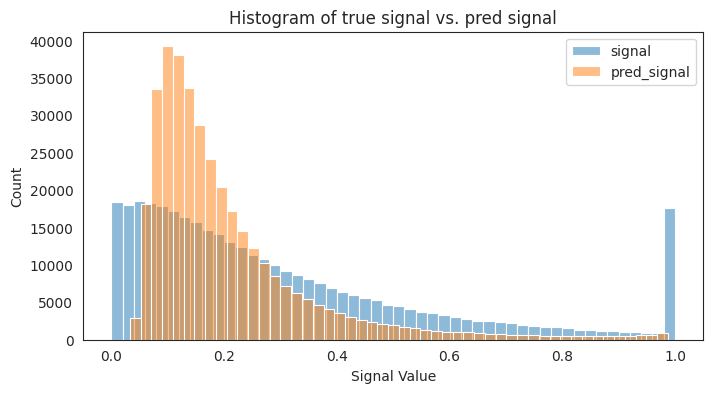

In [13]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

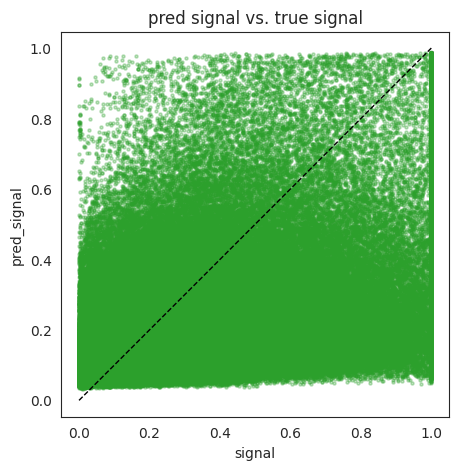

In [14]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

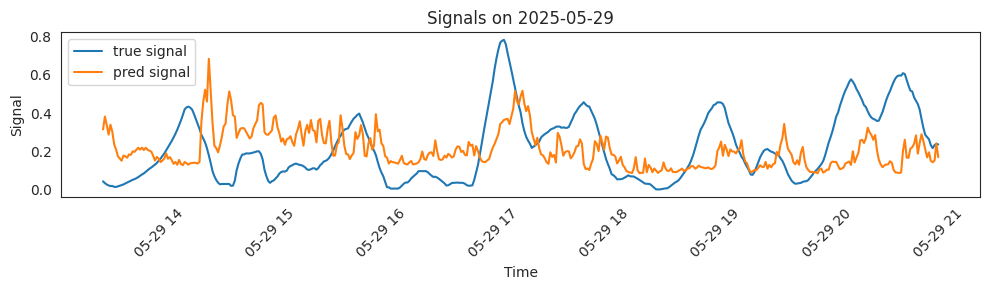

In [15]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-15]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal'], label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

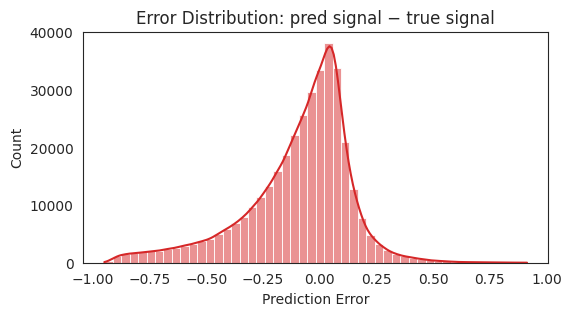

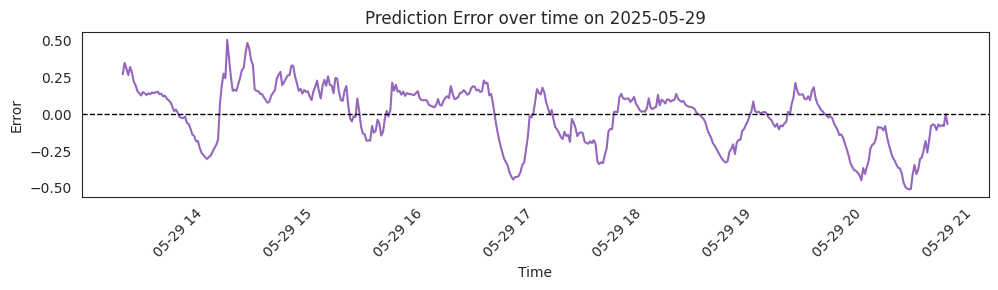

In [16]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# If running generate_trade_actions on a multi-day block, the in_trade flag won’t reset at midnight. Splitting by day below avoids that.

# Simulate per‐day to avoid cross‐midnight state carry‐over
sim_results = {}
groups     = list(df_test.groupby(df_test.index.normalize()))
print(f"Processing {len(groups)} days of predictions…")

for day, df_day in tqdm(groups, desc="Generate+Simulate"):
    # a) Generate discrete actions from the continuous signal
    df_actions = trades.generate_trade_actions(
        df                = df_day,
        col_signal        = "pred_signal", # name for the signal column to use
        col_action        = "pred_action", # name for the trade-action column to add
        buy_threshold     = params.pred_threshold_tick,
        trailing_stop_pct = params.trailing_stop_pred_tick,
        sess_start        = params.sess_start,
        col_close         = "close_mid"    # name of the column to use for price
    )

    # b) Run the backtest on this single‐day DataFrame
    single_result = trades.simulate_trading(
        results_by_day_sign = {day: (df_actions, [])},
        col_action          = "pred_action",
        sess_start          = params.sess_start,
        sess_end            = params.sess_end,
        ticker              = params.ticker
    )
    sim_results.update(single_result)

# final: sim_results holds each day → (df_sim, trades, stats)


Processing 809 days of predictions…


Generate+Simulate:   0%|          | 0/809 [00:00<?, ?it/s]


Plotting days in 2023-09:


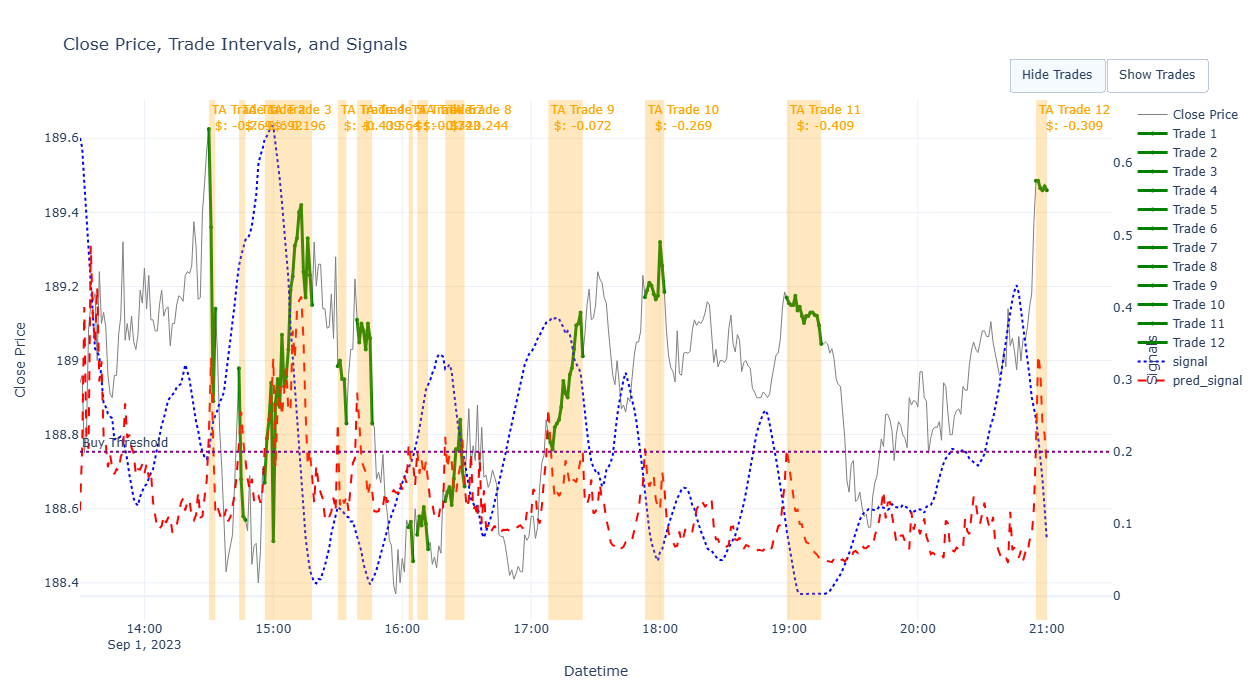


=== Performance for 2023-09-01 00:00:00 ===
Buy & Hold Return ($): -0.449
Strategy Return ($): -4.264
Trades Returns ($): [-0.769, -0.692, 0.196, -0.439, -0.564, -0.374, -0.323, -0.244, -0.072, -0.269, -0.409, -0.309]


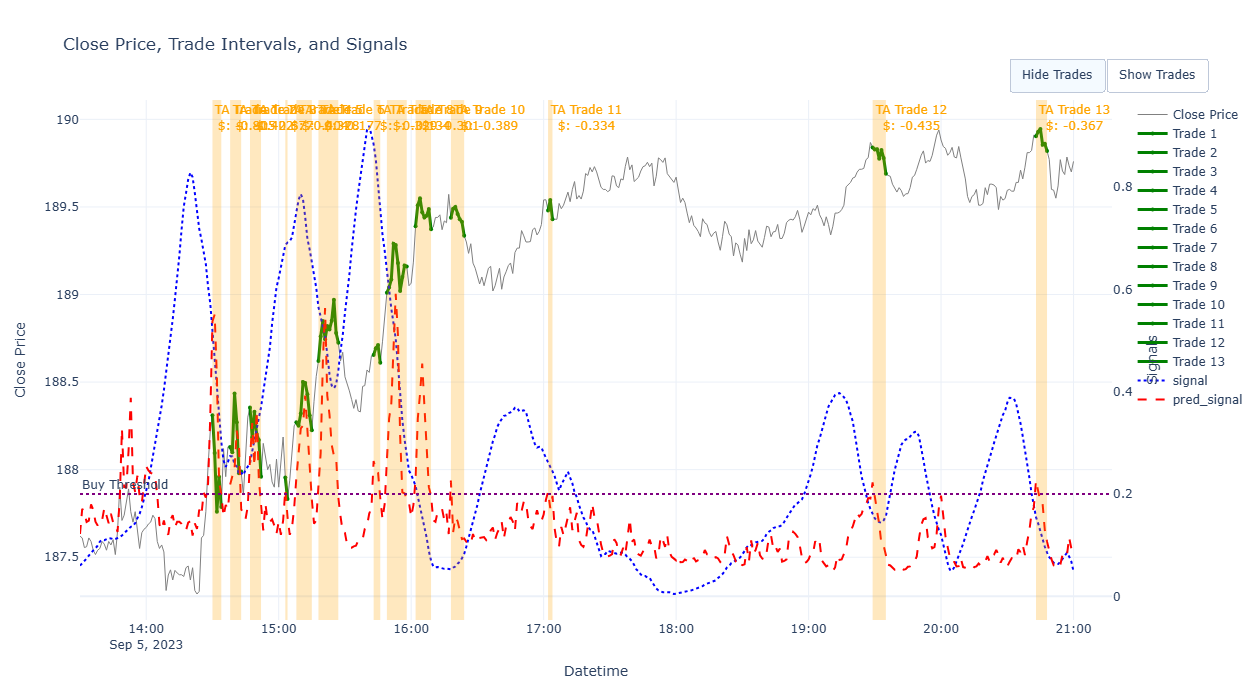


=== Performance for 2023-09-05 00:00:00 ===
Buy & Hold Return ($): 1.167
Strategy Return ($): -5.102
Trades Returns ($): [-0.805, -0.422, -0.677, -0.404, -0.328, -0.177, -0.329, -0.134, -0.301, -0.389, -0.334, -0.435, -0.367]


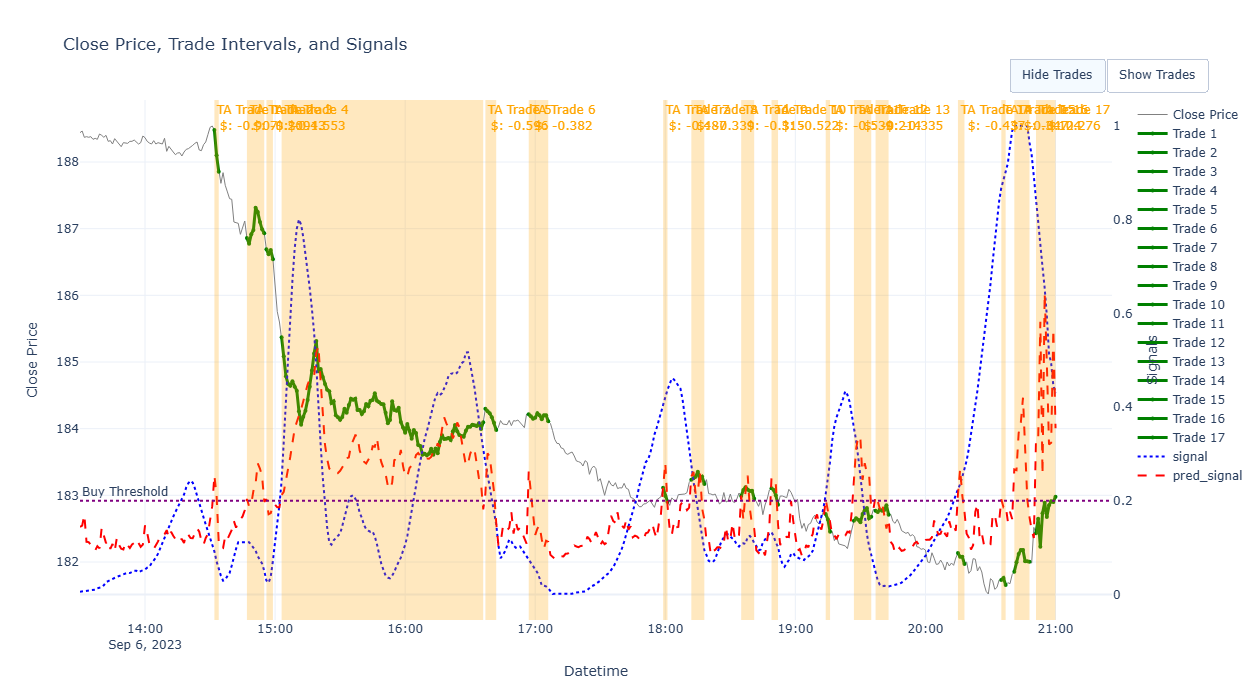


=== Performance for 2023-09-06 00:00:00 ===
Buy & Hold Return ($): -5.819
Strategy Return ($): -7.46
Trades Returns ($): [-0.907, -0.209, -0.43, -1.553, -0.596, -0.382, -0.487, -0.339, -0.315, -0.522, -0.539, -0.214, -0.335, -0.437, -0.347, -0.124, 0.276]


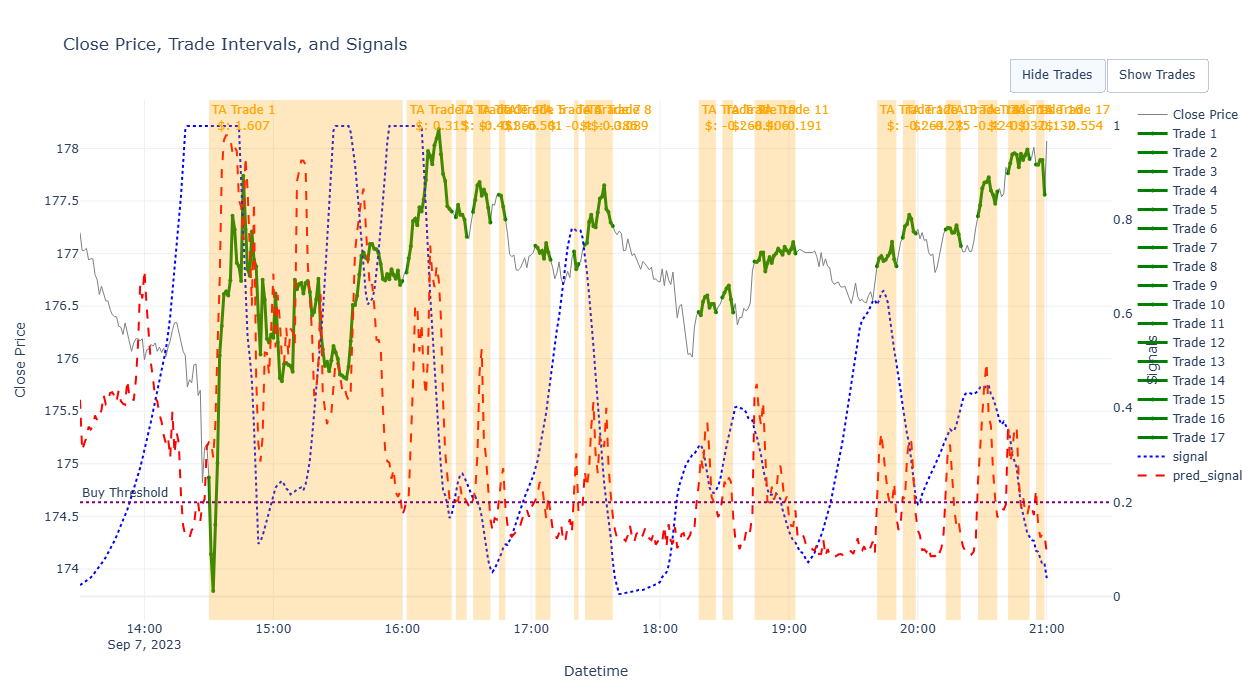


=== Performance for 2023-09-07 00:00:00 ===
Buy & Hold Return ($): 2.935
Strategy Return ($): -2.768
Trades Returns ($): [1.607, 0.315, -0.451, -0.366, -0.501, -0.4, -0.386, -0.089, -0.268, -0.406, -0.191, -0.264, -0.225, -0.424, -0.032, -0.132, -0.554]


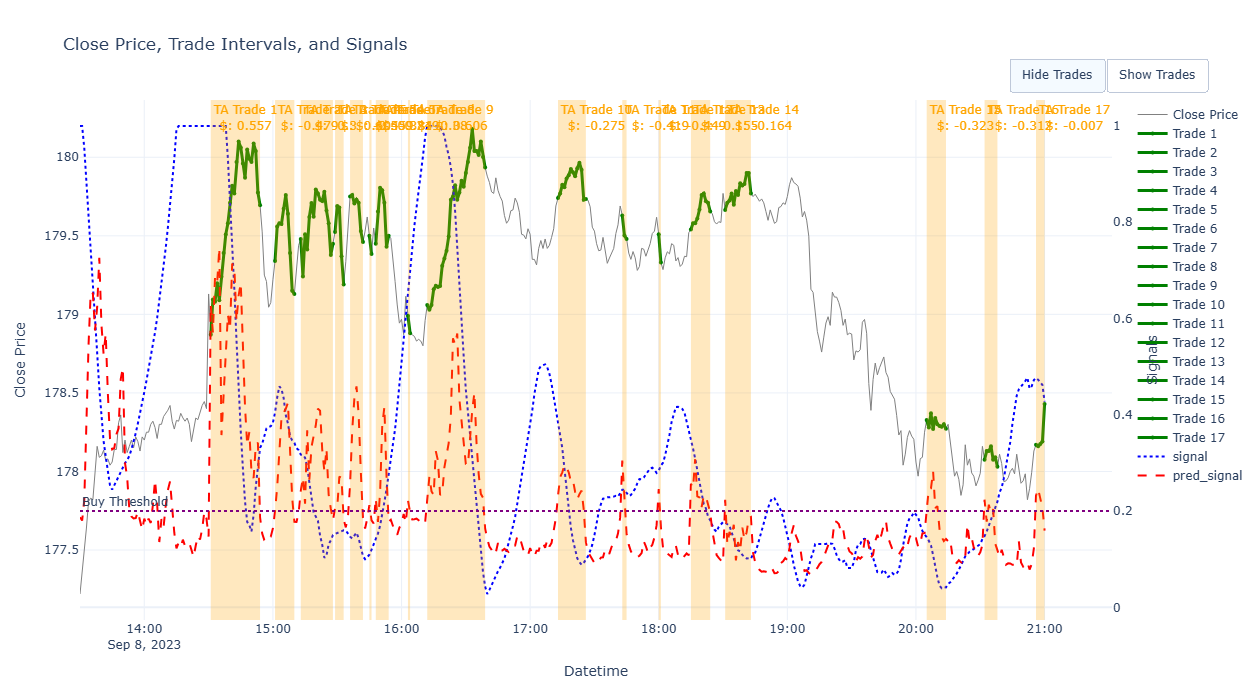


=== Performance for 2023-09-08 00:00:00 ===
Buy & Hold Return ($): -0.968
Strategy Return ($): -3.867
Trades Returns ($): [0.557, -0.479, -0.3, -0.604, -0.559, -0.384, -0.219, -0.38, 0.606, -0.275, -0.419, -0.449, -0.155, -0.164, -0.323, -0.312, -0.007]


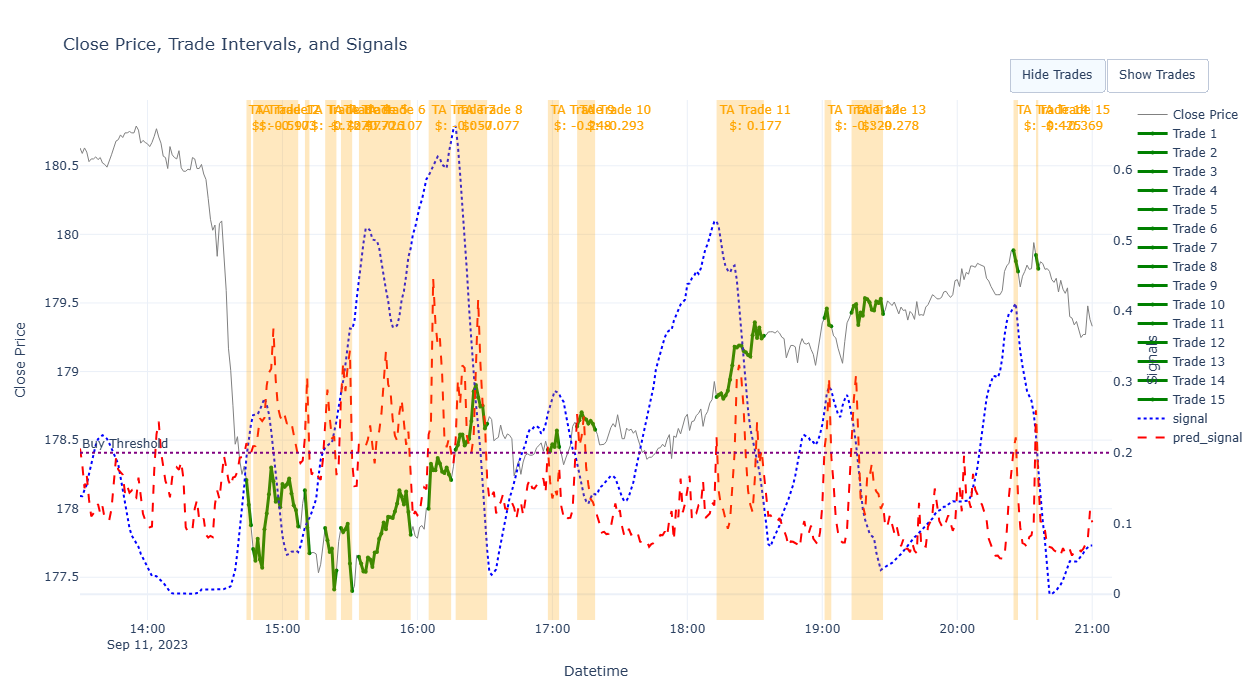


=== Performance for 2023-09-11 00:00:00 ===
Buy & Hold Return ($): -1.007
Strategy Return ($): -4.735
Trades Returns ($): [-0.597, -0.103, -0.727, -0.577, -0.726, -0.107, -0.057, -0.077, -0.248, -0.293, 0.177, -0.329, -0.278, -0.425, -0.369]


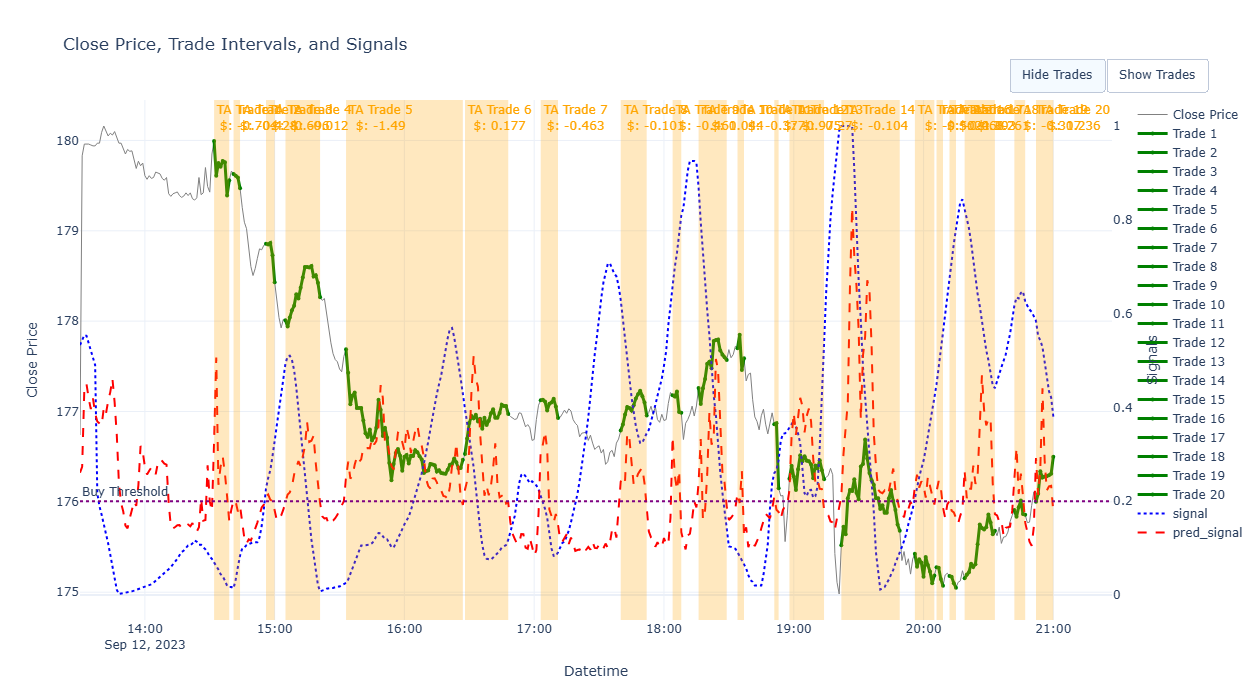


=== Performance for 2023-09-12 00:00:00 ===
Buy & Hold Return ($): -3.195
Strategy Return ($): -7.044
Trades Returns ($): [-0.704, -0.428, -0.696, -0.012, -1.49, 0.177, -0.463, -0.101, -0.461, 0.044, -0.377, -0.975, -0.27, -0.104, -0.502, -0.468, -0.393, 0.261, -0.317, 0.236]


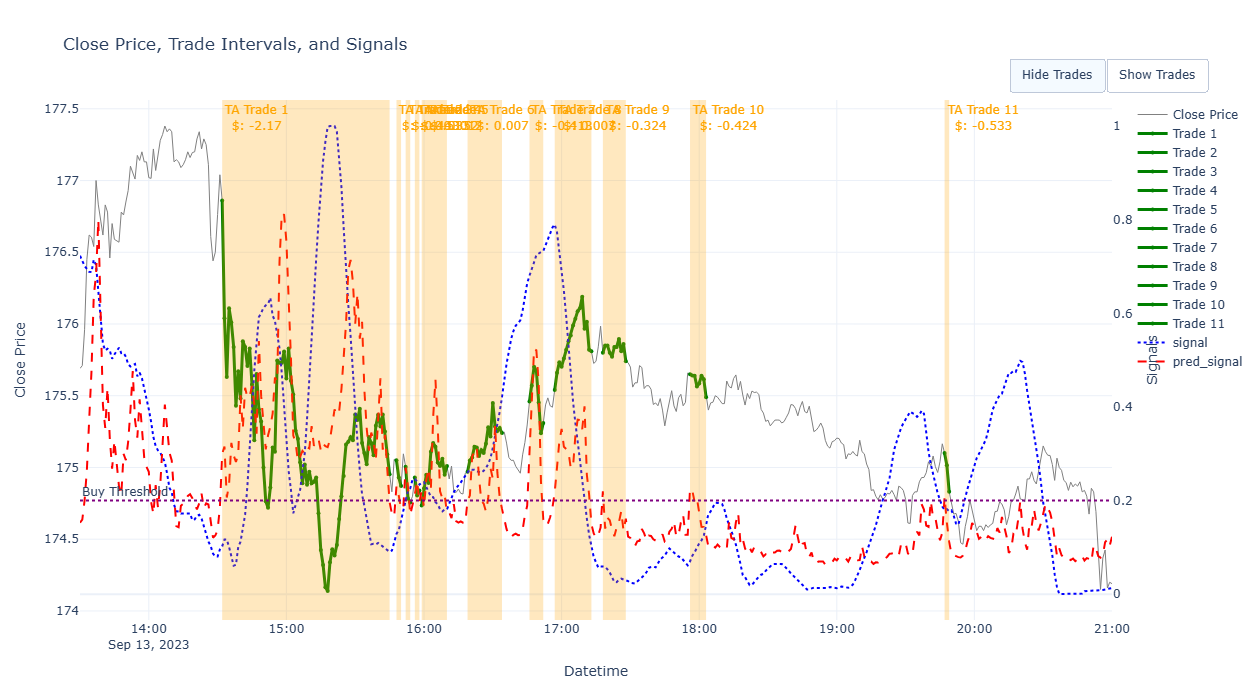


=== Performance for 2023-09-13 00:00:00 ===
Buy & Hold Return ($): -2.836
Strategy Return ($): -5.144
Trades Returns ($): [-2.17, -0.443, -0.513, -0.352, 0.012, 0.007, -0.413, 0.007, -0.324, -0.424, -0.533]


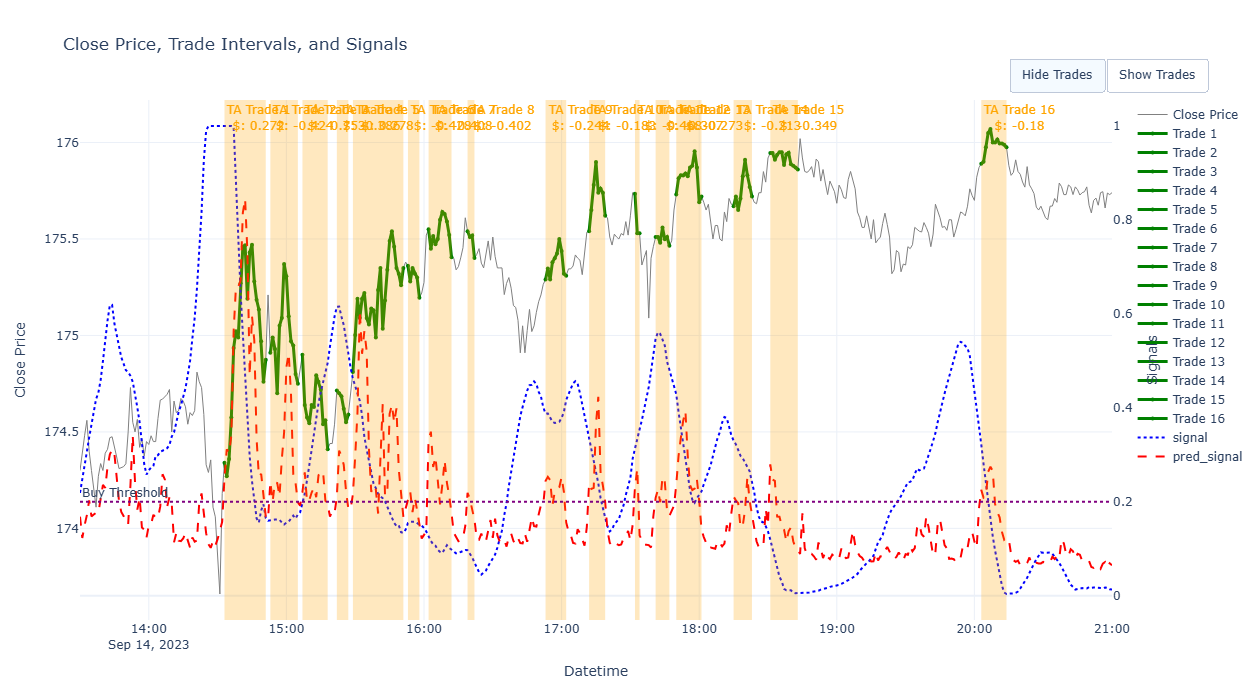


=== Performance for 2023-09-14 00:00:00 ===
Buy & Hold Return ($): 1.605
Strategy Return ($): -4.469
Trades Returns ($): [0.272, -0.424, -0.753, -0.386, 0.278, -0.428, -0.408, -0.402, -0.244, -0.183, -0.468, -0.307, -0.273, -0.213, -0.349, -0.18]


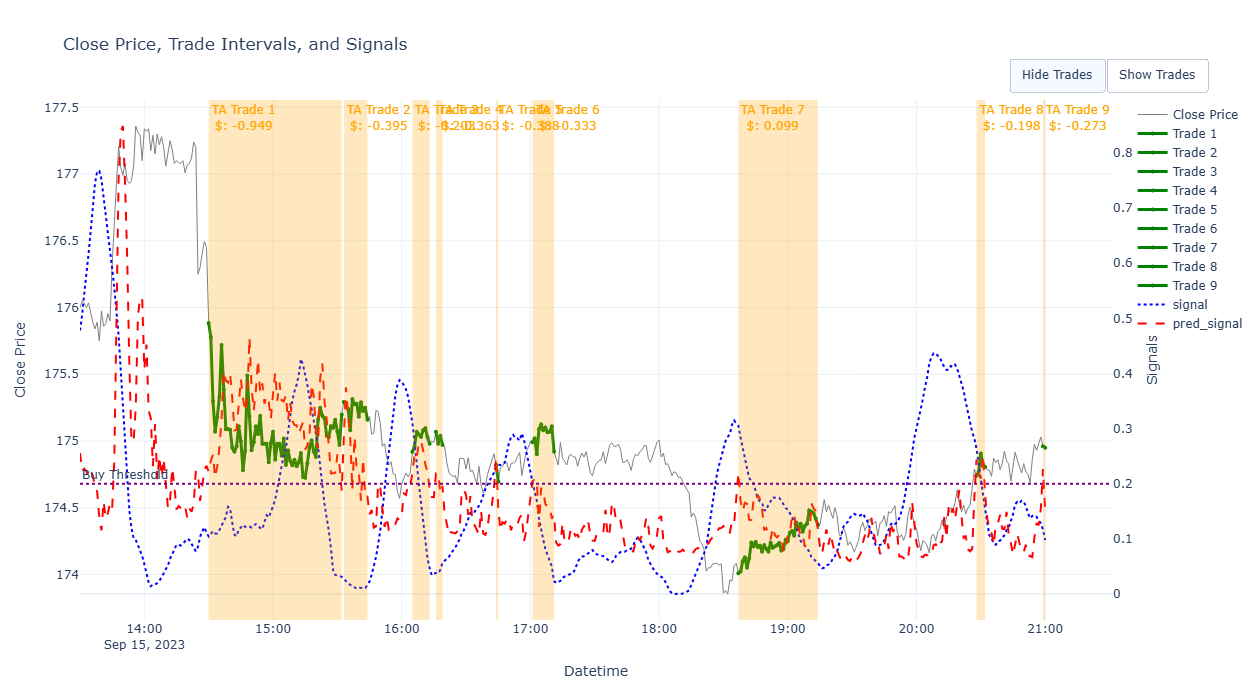


=== Performance for 2023-09-15 00:00:00 ===
Buy & Hold Return ($): -1.198
Strategy Return ($): -3.001
Trades Returns ($): [-0.949, -0.395, -0.203, -0.363, -0.388, -0.333, 0.099, -0.198, -0.273]


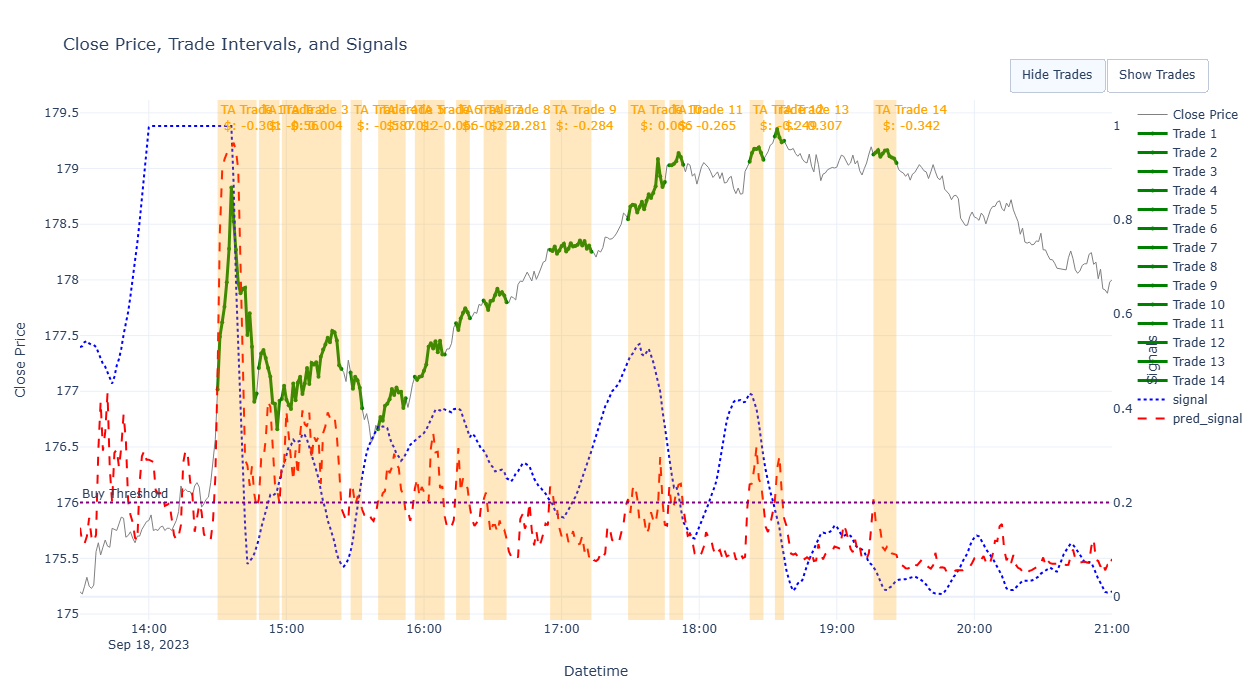


=== Performance for 2023-09-18 00:00:00 ===
Buy & Hold Return ($): 0.72
Strategy Return ($): -3.38
Trades Returns ($): [-0.301, -0.56, 0.004, -0.587, 0.012, -0.066, -0.222, -0.281, -0.284, 0.066, -0.265, -0.249, -0.307, -0.342]


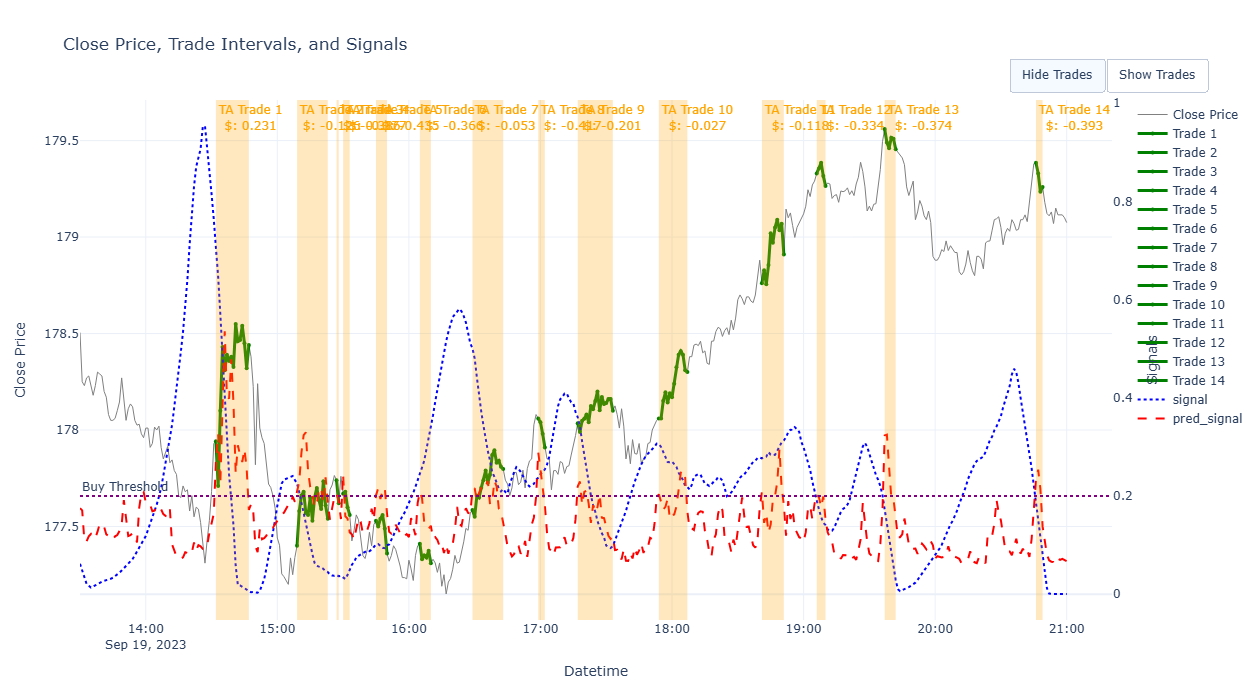


=== Performance for 2023-09-19 00:00:00 ===
Buy & Hold Return ($): 1.127
Strategy Return ($): -3.381
Trades Returns ($): [0.231, -0.126, -0.386, -0.377, -0.435, -0.366, -0.053, -0.417, -0.201, -0.027, -0.118, -0.334, -0.374, -0.393]


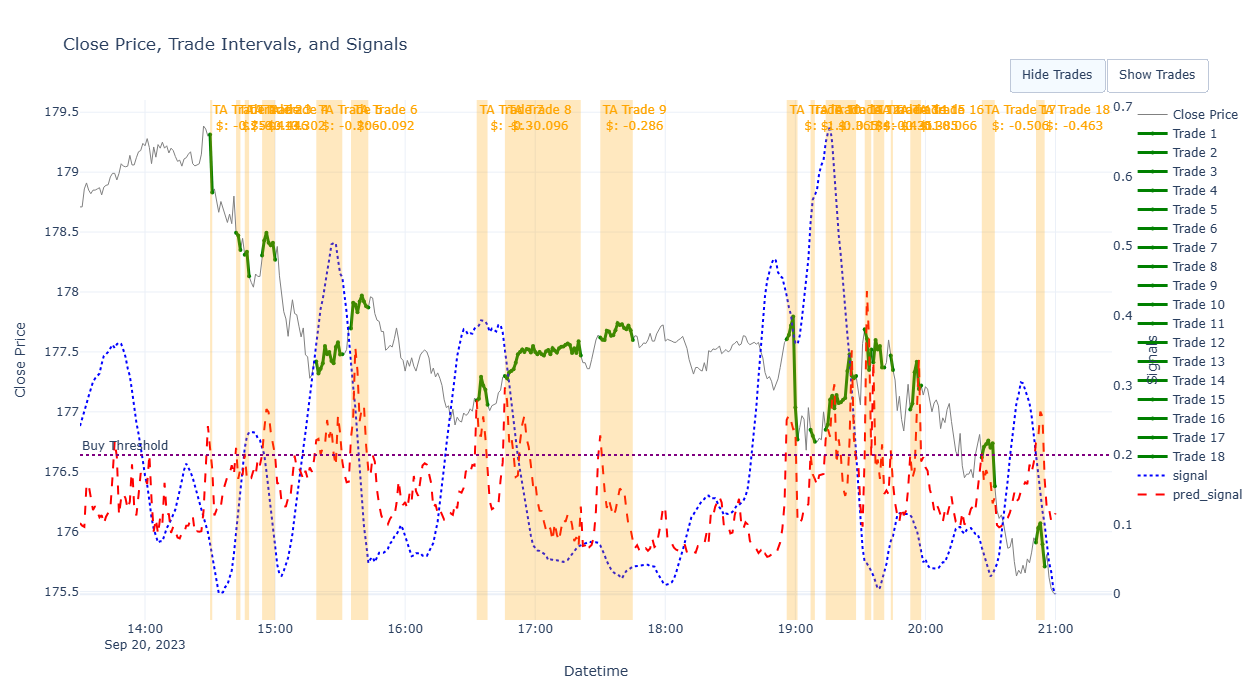


=== Performance for 2023-09-20 00:00:00 ===
Buy & Hold Return ($): -4.101
Strategy Return ($): -6.343
Trades Returns ($): [-0.754, -0.413, -0.446, -0.302, -0.206, -0.092, -0.3, -0.096, -0.286, -1.1, -0.365, 0.184, -0.436, -0.311, -0.385, -0.066, -0.506, -0.463]


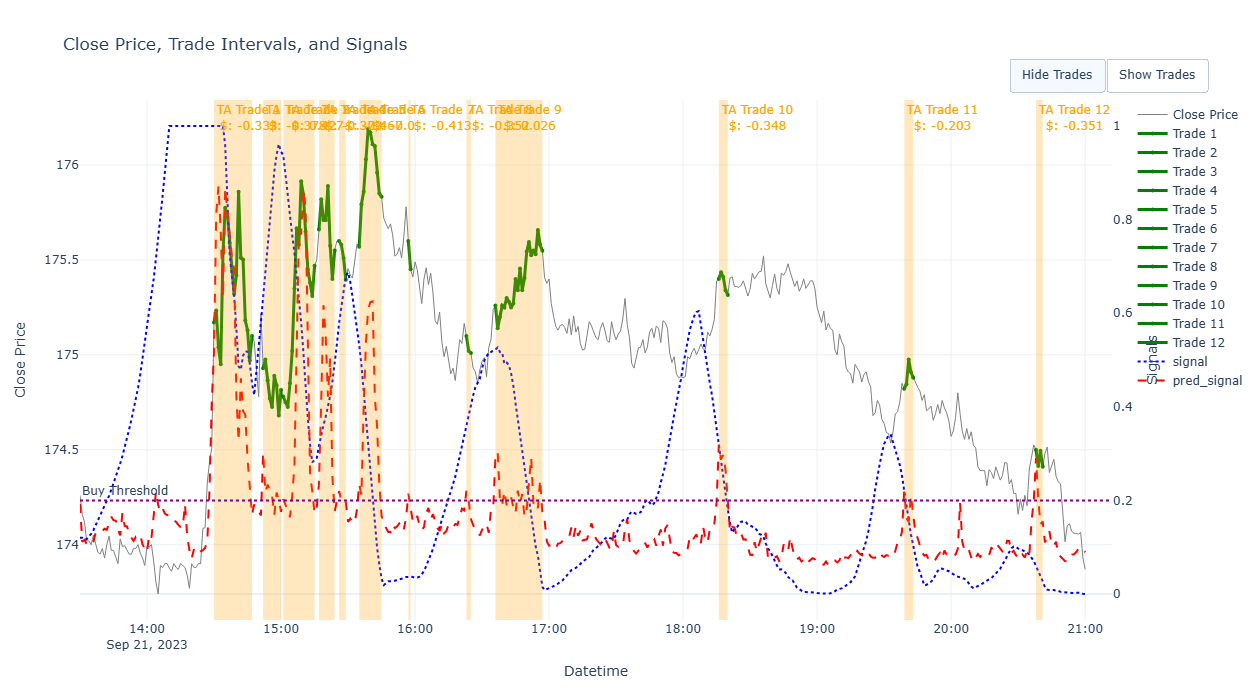


=== Performance for 2023-09-21 00:00:00 ===
Buy & Hold Return ($): -1.562
Strategy Return ($): -2.768
Trades Returns ($): [-0.333, -0.378, 0.427, -0.373, -0.467, -0.0, -0.413, -0.352, 0.026, -0.348, -0.203, -0.351]


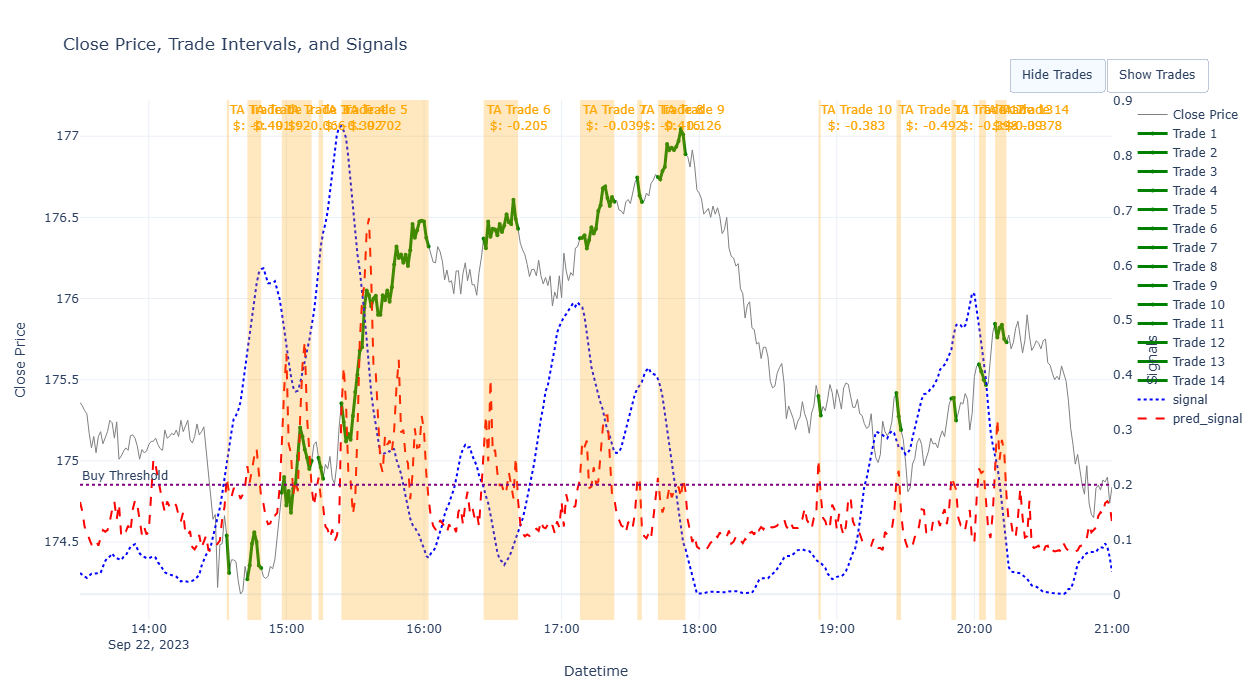


=== Performance for 2023-09-22 00:00:00 ===
Buy & Hold Return ($): 0.358
Strategy Return ($): -3.267
Trades Returns ($): [-0.491, -0.192, -0.066, -0.392, 0.702, -0.205, -0.039, -0.416, -0.126, -0.383, -0.492, -0.398, -0.39, -0.378]


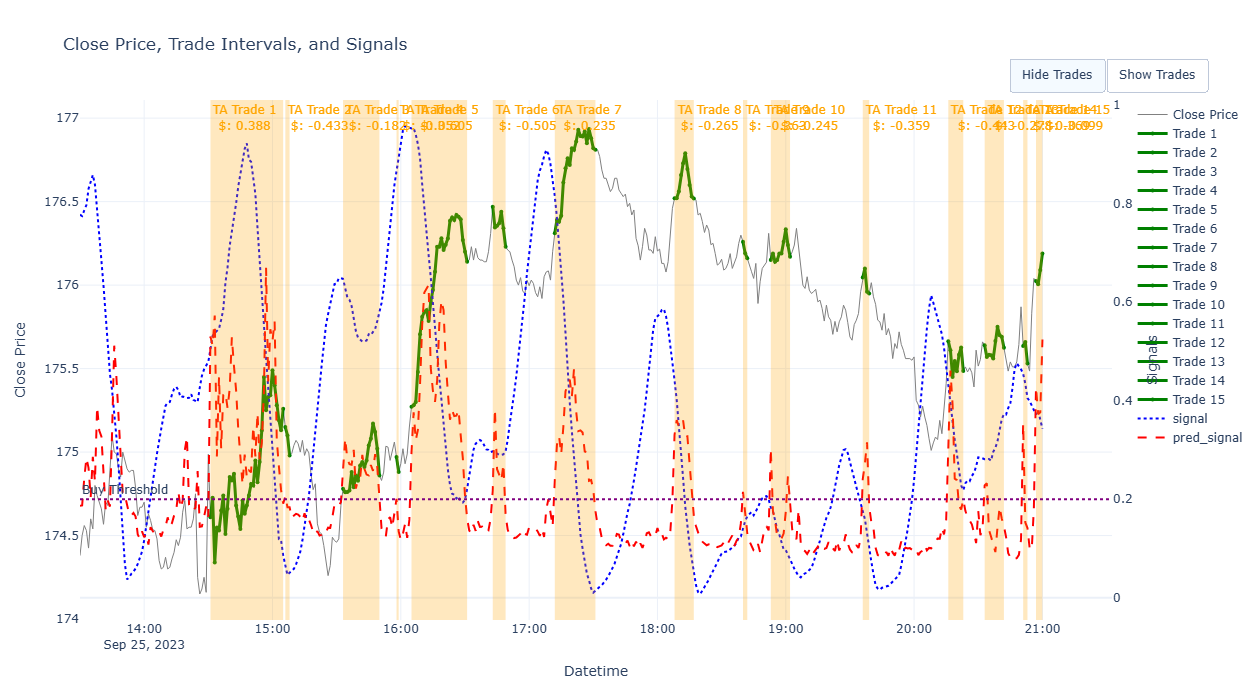


=== Performance for 2023-09-25 00:00:00 ===
Buy & Hold Return ($): 0.94
Strategy Return ($): -2.665
Trades Returns ($): [0.388, -0.433, -0.182, -0.352, 0.605, -0.505, 0.235, -0.265, -0.363, -0.245, -0.359, -0.443, -0.278, -0.369, -0.099]


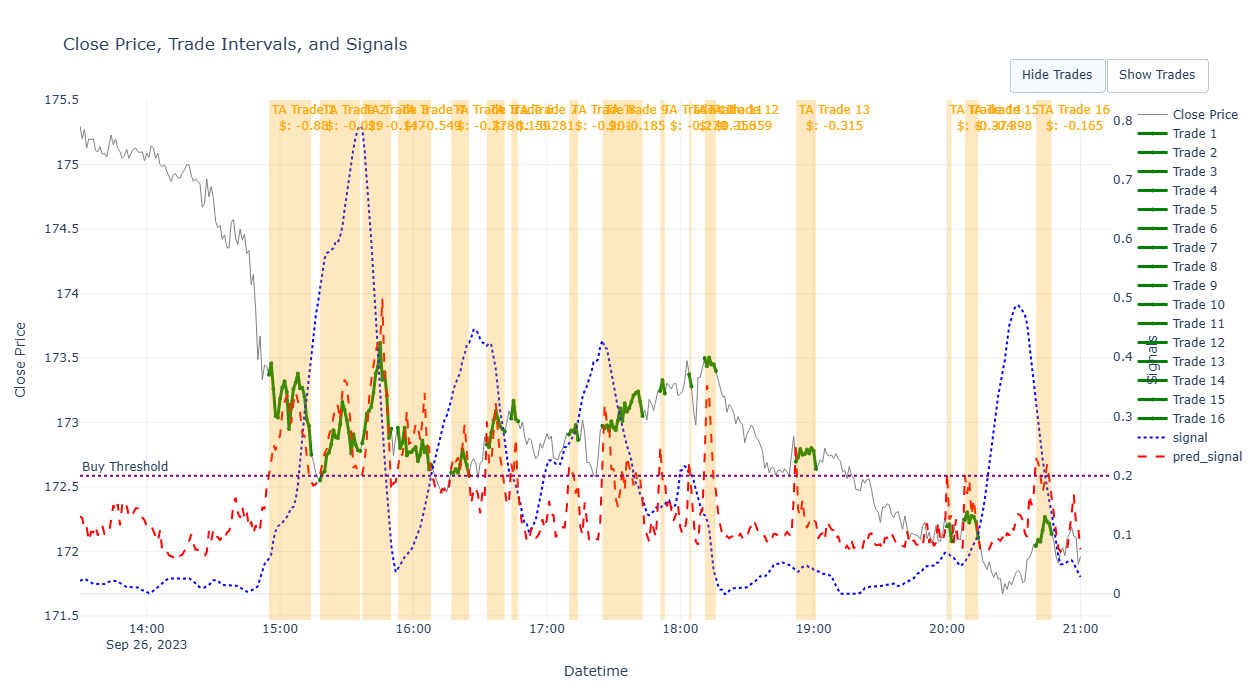


=== Performance for 2023-09-26 00:00:00 ===
Buy & Hold Return ($): -3.04
Strategy Return ($): -5.055
Trades Returns ($): [-0.88, -0.029, -0.147, -0.549, -0.278, -0.159, -0.281, -0.301, -0.185, -0.279, -0.356, -0.359, -0.315, -0.374, -0.398, -0.165]


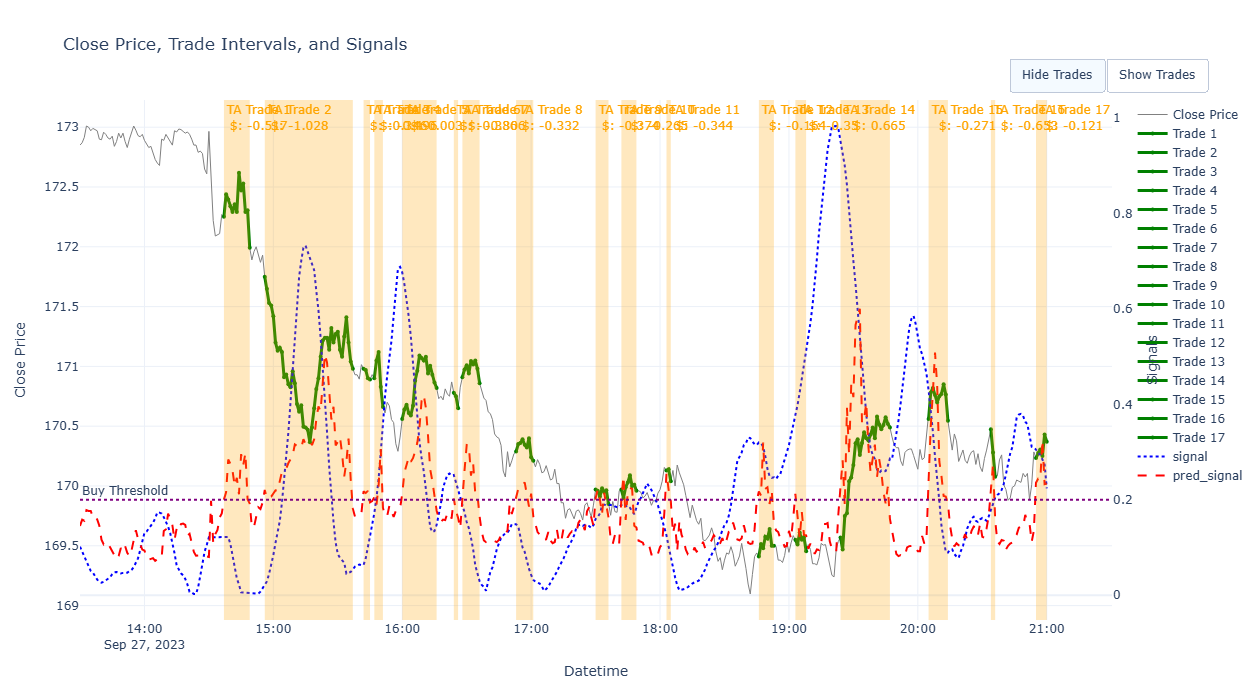


=== Performance for 2023-09-27 00:00:00 ===
Buy & Hold Return ($): -2.852
Strategy Return ($): -5.287
Trades Returns ($): [-0.517, -1.028, -0.346, -0.496, 0.003, -0.386, -0.306, -0.332, -0.374, -0.265, -0.344, -0.164, -0.35, 0.665, -0.271, -0.653, -0.121]


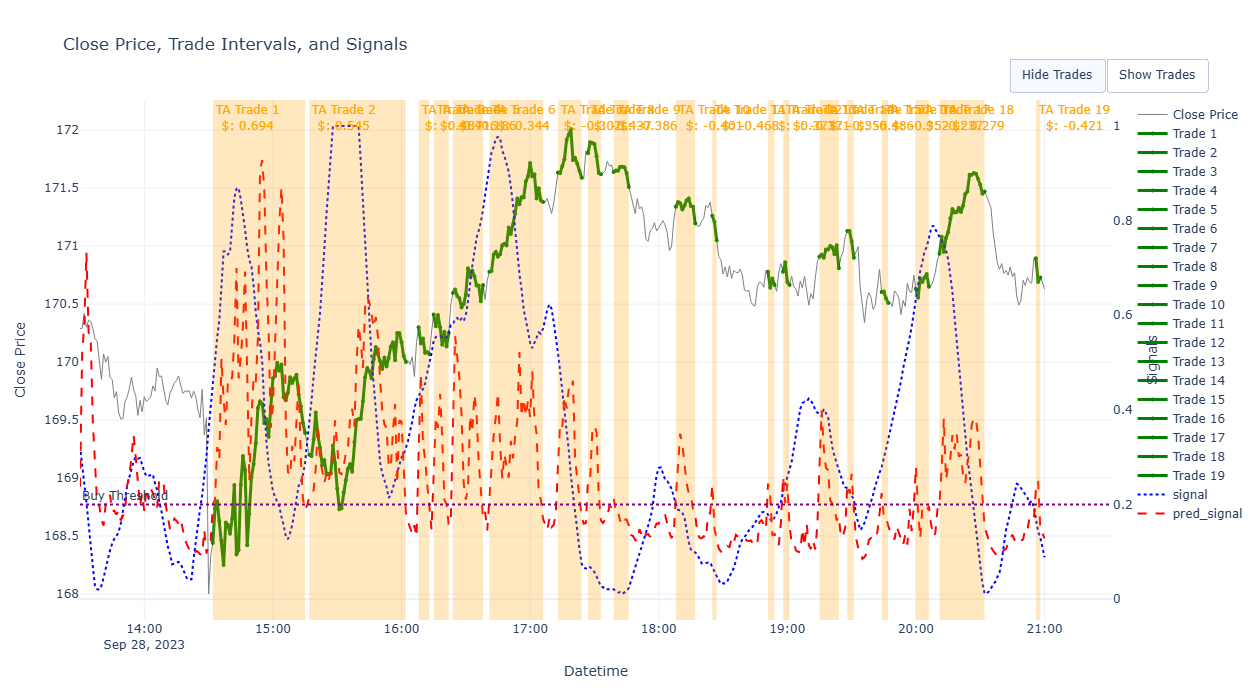


=== Performance for 2023-09-28 00:00:00 ===
Buy & Hold Return ($): 2.376
Strategy Return ($): -3.818
Trades Returns ($): [0.694, 0.545, -0.487, -0.416, -0.186, 0.344, -0.302, -0.437, -0.386, -0.401, -0.468, -0.371, -0.371, -0.356, -0.486, -0.352, -0.237, 0.279, -0.421]


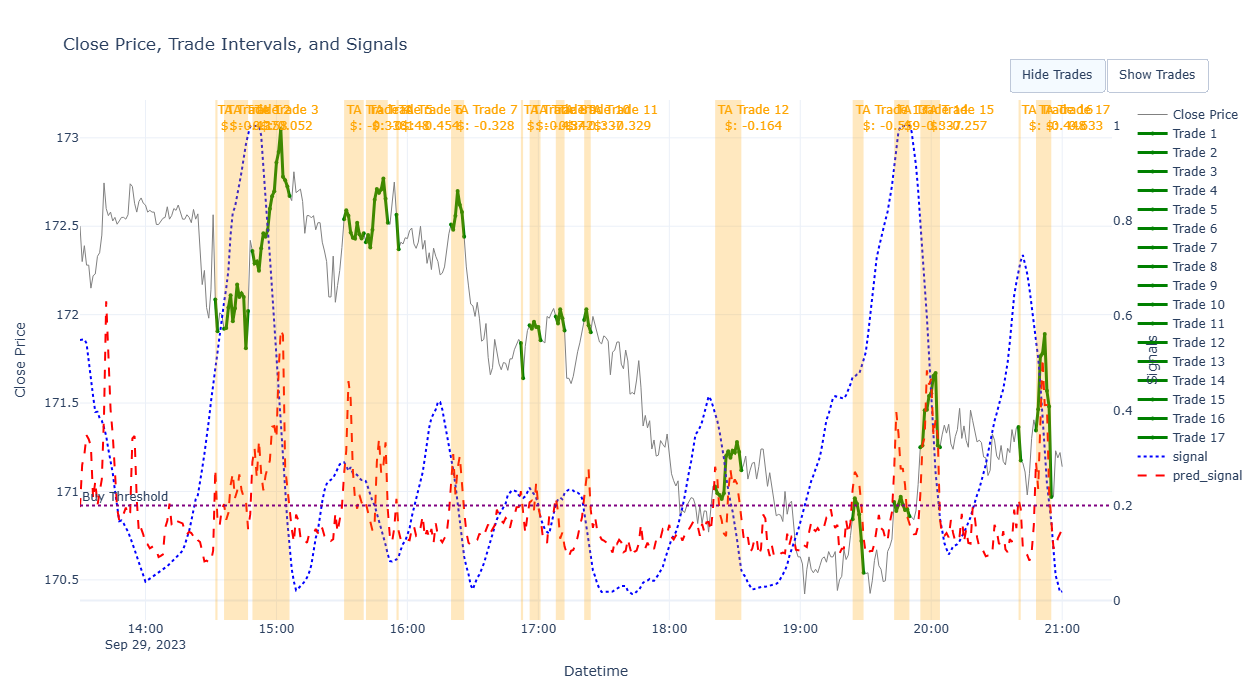


=== Performance for 2023-09-29 00:00:00 ===
Buy & Hold Return ($): -1.258
Strategy Return ($): -5.675
Trades Returns ($): [-0.437, -0.158, 0.052, -0.338, -0.148, -0.454, -0.328, -0.457, -0.342, -0.337, -0.329, -0.164, -0.559, -0.337, -0.257, -0.448, -0.633]

Overall Summary (2023-09-01 = 189.7672 → 2023-09-29 = 171.0116)

One-time buy&hold gain: -18.756
Buy & Hold – each day ($): -17.057
Strategy Return ($): -89.493
Trades Count: 303
Strategy return per trade: -0.295
Num. trading days: 20
Strategy return per trading day: -4.475


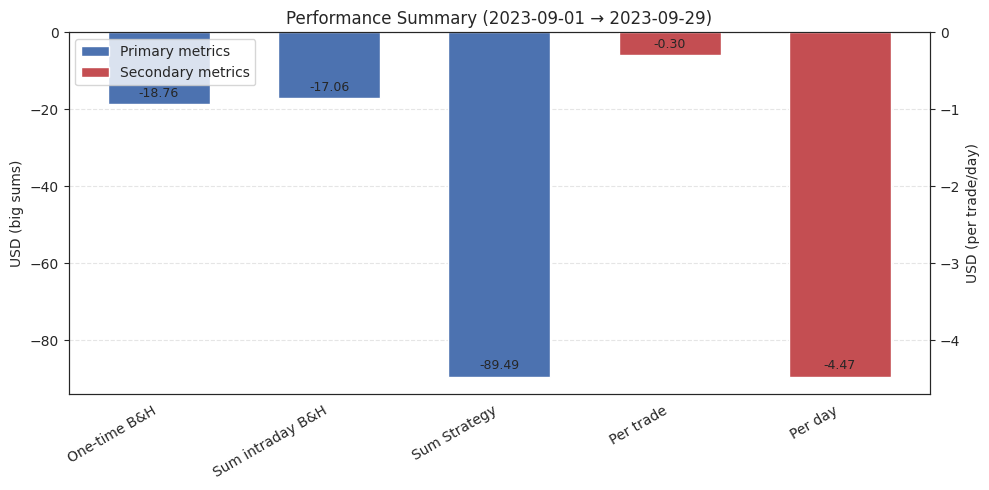


Overall Summary (2022-03-29 = 177.0727 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 19.320
Buy & Hold – each day ($): -192.076
Strategy Return ($): -3045.552
Trades Count: 10907
Strategy return per trade: -0.279
Num. trading days: 809
Strategy return per trading day: -3.765


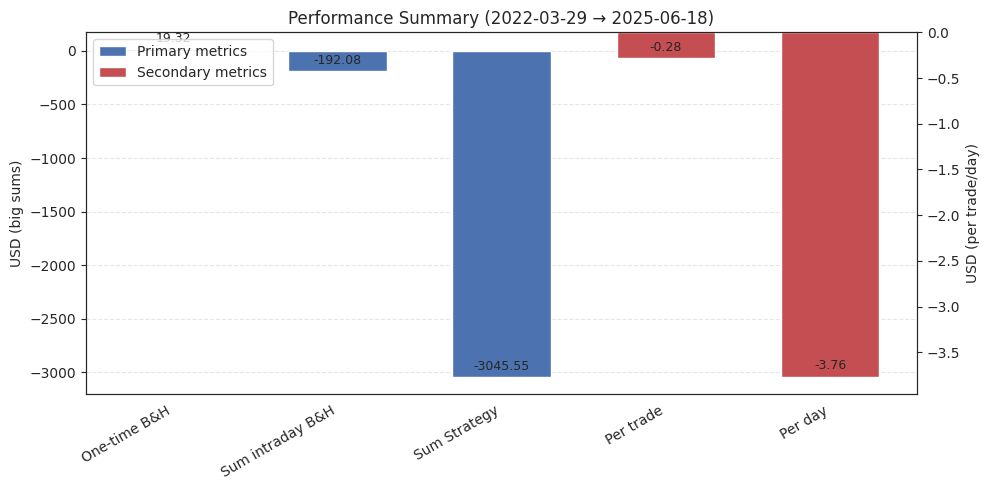

In [18]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_check

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        df_sim["close_mid"] = (df_sim["bid"] + df_sim["ask"]) / 2 # to quickly get back the original close column (not scaled) to use in the plot_trades function
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats,
            close_price       = 'close_mid' 
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)